# Reference
[uproot documentation](https://uproot.readthedocs.io/en/latest/)

# File management and helper classes

You'll find a Python module uproot_io alongside this notebook that provides some functions to process the ROOT files such that you shouldn't need to worry about how things are stored by uproot.

This sets up two classes, Events and View. The Events class holds all of the information loaded from a ROOT file (example usage is given below), as well as a couple of functions to help with filtering information by event number and PDG code. There's also a make_sequential function you don't need to worry about, which handles some technicalities around event number uniqueness. Examples using these filtering functions are given below.

You'll want to have a look at the Event class in particular, as the `__init__` function's  self.* variables represent all of the information you'll have access to. You won't necessarily need all (or even most) of these variables, but it's worthwhile to become familar with what's available.

View (a synonym for wire plane) is a helper class that can take an Event object and extract a core subset of information from an event in a given wire plane (most relevant to the BSc project). Each event in a View object is a collection of all hit coordinates in x (common to all wire planes) and z (the 'depth' in the U, V or W view as appropriate), their corresponding ADC values and the true vertex location in the coordinates of the relevant wire plane.

An example event display using View is given below.

In [1]:
from uproot_io import Events, View
import numpy as np

# Interaction type lookup table

interaction_dictionary is a simple lookup table that takes the numerical interaction type  from the Events class and converts it to a human readable string, e.g.

`   interaction_dictionary[3]`

returns

`   'CCQEL_MU_P_P_P'`

indicating that an interaction type code of 3 happens to represent a charged-current quasi-elastic interaction with a muon and three protons in the final state.

In [2]:
# Interaction type lookup
import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
# print(interaction_dictionary)

# Get data from tree

In [3]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [4]:
events.event_number

array([   0,    0,    0, ..., 9309, 9309, 9309], dtype=int32)

In [76]:
idx = np.where(events.event_number == 463)

In [77]:
idx

(array([28208, 28209]),)

In [57]:
np.where(events.interaction_type == 6)

(array([ 28208,  28209,  29569, ..., 515402, 515403, 515554]),)

In [28]:
interaction_dictionary

{0: 'CCQEL_MU',
 1: 'CCQEL_MU_P',
 2: 'CCQEL_MU_P_P',
 3: 'CCQEL_MU_P_P_P',
 4: 'CCQEL_MU_P_P_P_P',
 5: 'CCQEL_MU_P_P_P_P_P',
 6: 'CCQEL_E',
 7: 'CCQEL_E_P',
 8: 'CCQEL_E_P_P',
 9: 'CCQEL_E_P_P_P',
 10: 'CCQEL_E_P_P_P_P',
 11: 'CCQEL_E_P_P_P_P_P',
 12: 'NCQEL_P',
 13: 'NCQEL_P_P',
 14: 'NCQEL_P_P_P',
 15: 'NCQEL_P_P_P_P',
 16: 'NCQEL_P_P_P_P_P',
 17: 'CCRES_MU',
 18: 'CCRES_MU_P',
 19: 'CCRES_MU_P_P',
 20: 'CCRES_MU_P_P_P',
 21: 'CCRES_MU_P_P_P_P',
 22: 'CCRES_MU_P_P_P_P_P',
 23: 'CCRES_MU_PIPLUS',
 24: 'CCRES_MU_P_PIPLUS',
 25: 'CCRES_MU_P_P_PIPLUS',
 26: 'CCRES_MU_P_P_P_PIPLUS',
 27: 'CCRES_MU_P_P_P_P_PIPLUS',
 28: 'CCRES_MU_P_P_P_P_P_PIPLUS',
 29: 'CCRES_MU_PHOTON',
 30: 'CCRES_MU_P_PHOTON',
 31: 'CCRES_MU_P_P_PHOTON',
 32: 'CCRES_MU_P_P_P_PHOTON',
 33: 'CCRES_MU_P_P_P_P_PHOTON',
 34: 'CCRES_MU_P_P_P_P_P_PHOTON',
 35: 'CCRES_MU_PIZERO',
 36: 'CCRES_MU_P_PIZERO',
 37: 'CCRES_MU_P_P_PIZERO',
 38: 'CCRES_MU_P_P_P_PIZERO',
 39: 'CCRES_MU_P_P_P_P_PIZERO',
 40: 'CCRES_MU_P_P_P_P_P_PIZERO'

# Extract hits in each view

Getting the hits from each view is quite simple, you need only pass in an Event object and specify the view you want. Now however, if you access a variable in the view and specify a specific event, e.g.

`view_w.z[1]`

you'll get back one array with all of the information for that event in the view of interest. All of the PFO details are lost, but this approach is very convenient for event displays (see below).

In [5]:
view_u = View(events, "u")
view_v = View(events, "v")
view_w = View(events, "w")

In [ ]:
view_w.z[1]

# Display an event

In [8]:
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

Event displays are useful. We encourage you to make extensive use of them in helping you to understand what you're algorithms are doing, both from the perspective of thinking through what you think your algorithm should do, where it might encounter problems, and also as a debugging tool - if you're trying to reconstruct a vertex location, plot it on the relevant event display, as this will be much easier to interpret than the raw numbers.

The example below plots an event display for event 15 in the W wire plane. This example provides a little insight into using different variables in View jointly (the process is similar for Event, though keep in mind most variables in Event are sets of arrays, not single blocks). It also provides some plotting details that will hopefully be useful for constructing future plots.

The range of values of x and z covered by any given event is highly variable and so by default you can get some quite skewed aspect ratios from Python. So to help you understand what the events really look like it can be helpful to enforce a true aspect ratio, this is what get_fig_ratio supplies, and once you pick a size for a figure in x, you can use this to enforce a suitable scale in y via the figsize parameter of plt.subplots. You don't __have__ to do this, and sometimes using the true aspect ratio can be unhelpful if the ratio of z and x extents becomes very large/small, but if you have to think about angles between tracks this approach can prevent a lot of confusion.

You'll often want to provide standard formatting for axes, so this is providing by format_axis (note this assumes a single subplot, you'll want to call this in a loop if you are formatting multiple subplots, passing in each individual subplot axis).

In the event display below you can see the hits from event 15 (not a very exciting event) in various shades of blue, which represent the ADC contribution of each hit, this is achieved by using the view.adc variable to weight the hits at the corresponding coordinate (view.x and view.z). The binning is arbitrarily chosen to be 200 bins in each dimension, and the colour map and associated normalisation are specified. Again, these are arbitrary choices (you can omit them altogether), but I find this combination of colour map and normalisation to work reasonably well (i.e. a colour gradient that is easily interpreted from low to high values).

The true vertex is also added via the call to axes.scatter, where s is the marker size.

In [78]:
e = 463 # input event number

# 700

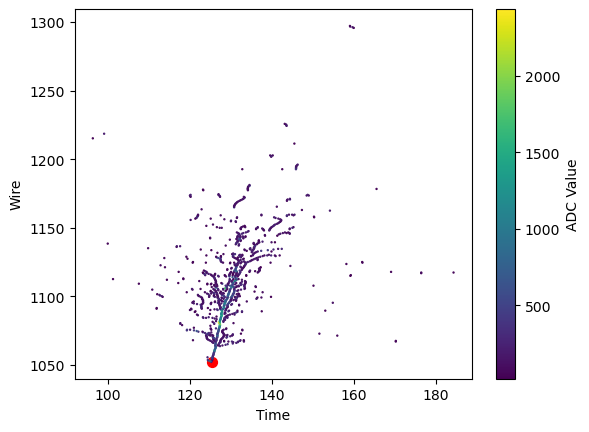

In [79]:
# EVENT VIEWER - W

x = view_w.x[e]
z = view_w.z[e]
adc = view_w.adc[e]
truez = view_w.true_vtx_z[e]
truex = view_w.true_vtx_x[e]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

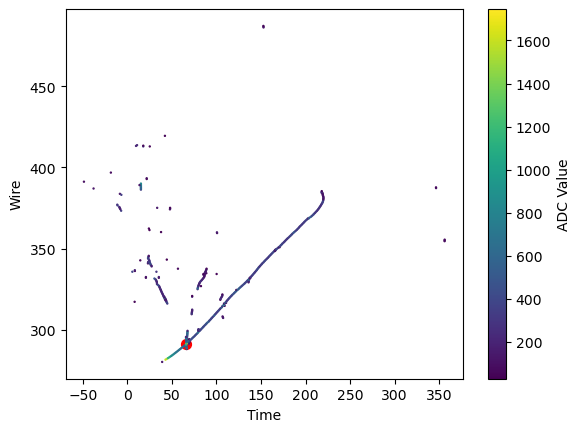

In [13]:
# EVENT VIEWER - U

x = view_u.x[e]
z = view_u.z[e]
adc = view_u.adc[e]
truez = view_u.true_vtx_z[e]
truex = view_u.true_vtx_x[e]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

In [14]:
# EVENT VIEWER - V

x = view_v.x[e]
z = view_v.z[e]
adc = view_v.adc[e]
truez = view_v.true_vtx_z[e]
truex = view_v.true_vtx_x[e]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_v' is not defined

In [15]:
#EVENT 0

x = view_w.x[0]
z = view_w.z[0]
adc = view_w.adc[0]
truez = view_w.true_vtx_z[0]
truex = view_w.true_vtx_x[0]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [16]:
#EVENT 1

x = view_w.x[1]
z = view_w.z[1]
adc = view_w.adc[1]
truez = view_w.true_vtx_z[1]
truex = view_w.true_vtx_x[1]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [17]:
#EVENT 2

x = view_w.x[2]
z = view_w.z[2]
adc = view_w.adc[2]
truez = view_w.true_vtx_z[2]
truex = view_w.true_vtx_x[2]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [18]:
#EVENT 3

x = view_w.x[3]
z = view_w.z[3]
adc = view_w.adc[3]
truez = view_w.true_vtx_z[3]
truex = view_w.true_vtx_x[3]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [19]:
#EVENT 4

x = view_w.x[4]
z = view_w.z[4]
adc = view_w.adc[4]
truez = view_w.true_vtx_z[4]
truex = view_w.true_vtx_x[4]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [20]:
#EVENT 5

x = view_w.x[5]
z = view_w.z[5]
adc = view_w.adc[5]
truez = view_w.true_vtx_z[5]
truex = view_w.true_vtx_x[5]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [21]:
# EVENT 6

x = view_w.x[6]
z = view_w.z[6]
adc = view_w.adc[6]
truez = view_w.true_vtx_z[6]
truex = view_w.true_vtx_x[6]

%matplotlib inline
plt.scatter(truex, truez, s=50, color='red')
plt.scatter(x, z, c=adc, s=0.5)
cbar = plt.colorbar()
plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

NameError: name 'view_w' is not defined

In [22]:
events.event_number

array([   0,    0,    0, ..., 9309, 9309, 9309], dtype=int32)

In [23]:
idx = np.where(events.event_number == 1)
idx

(array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),)

In [24]:
# EVENT ONE PARTICLES!

x = events.true_neutrino_vtx_x[0]
z = events.true_neutrino_vtx_w[0]

p1x = events.reco_hits_x_w[0]
p1 = events.reco_hits_w[0]

p2x = events.reco_hits_x_w[45]
p2 = events.reco_hits_w[45]


p3x = events.reco_hits_x_w[46]
p3 = events.reco_hits_w[46]

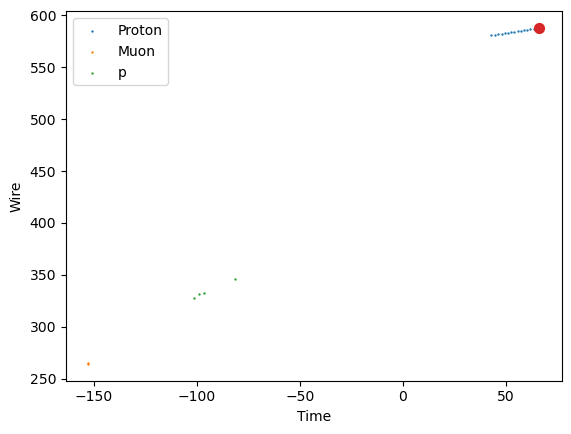

In [25]:
%matplotlib inline
# plt.scatter(truex, truez, s=50, color='red')
plt.scatter(p1x, p1, s=0.5, label='Proton')
plt.scatter(p2x, p2, s=0.5, label='Muon')
plt.scatter(p3x, p3, s=0.5, label='p')
plt.scatter(x, z, s=50)

plt.legend()
# cbar = plt.colorbar()
# plt.xlim(100, 250)

plt.xlabel("Time")
plt.ylabel("Wire")
cbar.set_label('ADC Value')

In [26]:
#FUNCTIONS!

In [27]:
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

def plot_w_event(number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()
    
def plot_u_event(number):
    x = view_u.x[number]
    z = view_u.z[number]
    adc = view_u.adc[number]
    vx = view_u.true_vtx_x[number]
    vz = view_u.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('U Wire')
    plt.show()

def plot_v_event(number):
    x = view_v.x[number]
    z = view_v.z[number]
    adc = view_v.adc[number]
    vx = view_v.true_vtx_x[number]
    vz = view_v.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('V Wire')
    plt.show()

def plot(number):
    plot_w_event(number)
    plot_u_event(number)
    plot_v_event(number)


plot(6)

NameError: name 'view_w' is not defined

In [29]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [30]:
list(set(events.event_number))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [31]:
event_name_dict = {}

for i in list(set(events.event_number)):
    idx = np.where(events.event_number == i)[0]
    typ = events.interaction_type[idx[0]]
    name = interaction_dictionary[typ]
    event_name_dict[i] = name

In [32]:
event_name_dict

{0: 'CCDIS_MU_P_P_P_P_PIZERO',
 1: 'OTHER_INTERACTION',
 2: 'CCRES_MU_P_P',
 3: 'NCDIS_P_PIMINUS',
 4: 'NCQEL_P',
 5: 'CCDIS_MU_P_PIPLUS',
 6: 'OTHER_INTERACTION',
 7: 'CCQEL_MU',
 8: 'OTHER_INTERACTION',
 9: 'NCDIS_PIZERO',
 10: 'CCQEL_MU_P',
 11: 'OTHER_INTERACTION',
 12: 'OTHER_INTERACTION',
 13: 'CCRES_MU_PIPLUS',
 14: 'OTHER_INTERACTION',
 15: 'CCRES_MU_P_PIZERO',
 16: 'CCRES_MU_P_PIPLUS',
 17: 'CCDIS_MU_P_PIPLUS',
 18: 'OTHER_INTERACTION',
 19: 'NCDIS_P_PIZERO',
 20: 'CCQEL_MU_P',
 21: 'CCRES_MU_PIPLUS',
 22: 'OTHER_INTERACTION',
 23: 'OTHER_INTERACTION',
 24: 'OTHER_INTERACTION',
 25: 'OTHER_INTERACTION',
 26: 'OTHER_INTERACTION',
 27: 'OTHER_INTERACTION',
 28: 'CCQEL_MU',
 29: 'OTHER_INTERACTION',
 30: 'CCQEL_MU_P',
 31: 'NCDIS_PIZERO',
 32: 'CCQEL_MU',
 33: 'CCQEL_MU_P',
 34: 'CCDIS_MU_P_PIPLUS',
 35: 'OTHER_INTERACTION',
 36: 'CCRES_MU_P_PIPLUS',
 37: 'OTHER_INTERACTION',
 38: 'OTHER_INTERACTION',
 39: 'CCDIS_MU_PIPLUS',
 40: 'OTHER_INTERACTION',
 41: 'OTHER_INTERACTION',
 42

28208


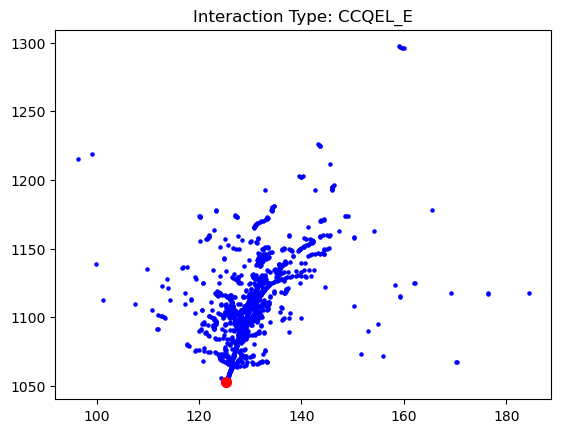

28209


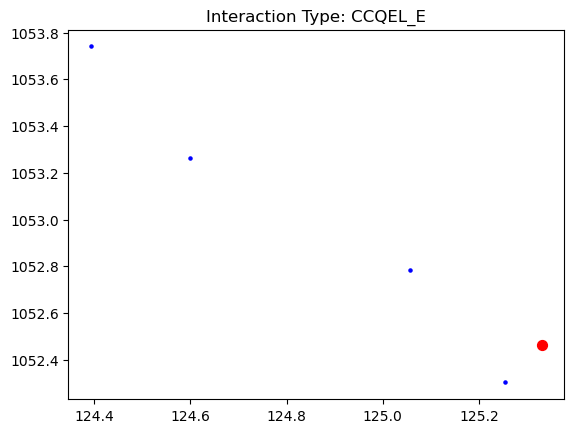

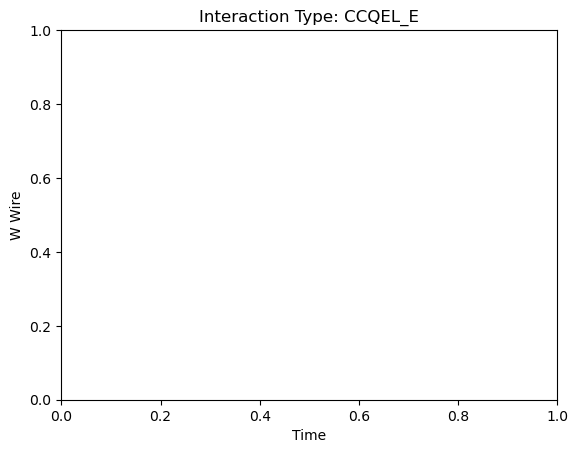

In [83]:
def plotparticles(event_number):
    idx = np.where(events.event_number == event_number)[0]
    
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    
    typ = events.interaction_type[idx[0]]
    name = interaction_dictionary[typ]
    
    for i in idx:
        print(i)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        plt.scatter(x, z, s=5, c='blue', label='Electron hits')
        plt.scatter(vx, vz, c='red', s=50)
        plt.title(f'Interaction Type: {name}')
        if i == 28208:
            plt.savefig('electron.png', dpi=500)
        plt.show()
    
#     vx = events.true_neutrino_vtx_x[idx[0]]
#     vz = events.true_neutrino_vtx_w[idx[0]]
#     plt.scatter(vx, vz, c='red', s=50)
    
#     typ = events.interaction_type[idx[0]]
#     name = interaction_dictionary[typ]
    
    plt.title(f'Interaction Type: {name}')
    plt.xlabel('Time')
    plt.ylabel('W Wire')

plotparticles(463)

In [ ]:
    idx = np.where(events.event_number == event_number)[0]
    
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]

x = events.reco_hits_x_w[i]
z = events.reco_hits_w[i]
plt.scatter(x, z, s=5, c='purple', label='Electron hits')
plt.scatter(vx, vz, c='red', s=50)
plt.title(f'Interaction Type: {name}')
plt.show()

# Saving plots and numpy arrays

Below is a simple utility function you can call whenever you want to save a plot, creating directories as needed and producing output both in png, jpg and in vector graphics format

In [32]:
import os

def save_plot(fig, directory, filename):
    if not os.path.exists(directory):
        os.mkdir(directory)
    fig.savefig(f'{directory}/{filename}.png', bbox_inches='tight', dpi=200, facecolor='w')
    fig.savefig(f'{directory}/{filename}.jpg', bbox_inches='tight', dpi=200)
    fig.savefig(f'{directory}/{filename}.svg', bbox_inches='tight', dpi=200)

You'll likely produce numpy arrays as either final results or intermediate steps, it's worth getting into the habit of saving at least some of these arrays. While you will often work with small subsets of the data when testing out new functions there will be times when you will need the larger datasets, and depending on the computational efficiency of your code, some of these steps may take quite a long time.

Python often has a reputation for being slow relative to languages like C++. This is often not actually true, and well written code, using core Python features like list comprehensions can be very fast (they're often compiled C code), but on large data sets, say 100,000 events or more, even very efficient code might take a minute or two, which will quickly get annoying in a debugging cycle, but for less Pythonic code with nested loops, this might turn into many hours, so for intermediate results in particular, you want to be able to run such steps once and then just load the result when you need to do some additional post-processing.

For this numpy.save("your_filename", your_array) and the corresponding your_array = numpy.load("your_filename") will be helpful. Test that these are working on small arrays early and then be sure to save large arrays as necessary, being careful to ensure you don't overwrite things you meant to keep.